### Dependencies

In [21]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

pd.set_option('display.max_columns', None)

import pickle

# importing libraries for flask
from flask import Flask, abort, jsonify, request, render_template

import joblib
import numpy as np
import json
import base64
import re

# importing dash to create dashboard
import dash

# Core components to plot graphs etc;
from dash import dcc

# html components
from dash import html

# Input, Output and State functions for the dashboard application
from dash.dependencies import Input, Output, State

# importing plotly graph objects to plot
import plotly.graph_objs as go

# dashborad authorisation dependencies
# import dash_auth

# import plotly.plotly as py

### Descripitive Analysis, clean and Prep

In [2]:
df = pd.read_csv("carscom_scrape_clean.csv").drop(['Unnamed: 0'], axis=1)
cars_df = df.copy()
cars_df = cars_df[['make', 'model', 'year', 'mileage', 'ratings', 'price']]
cars_df.head()

,make,model,year,mileage,ratings,price
0,Saturn,Aura,2009,94934.0,5.0,3990
1,Toyota,Tacoma,2009,145229.0,5.0,14990
2,Toyota,Tacoma,2004,136656.0,4.8,8850
3,Toyota,Tacoma,2005,175805.0,4.8,6450
4,Acura,MDX,2005,141313.0,4.8,4850


In [3]:
cars_df.shape

(5000, 6)

In [4]:
# correcting price
cars_df['price'] = [re.findall(r'\d+', i)[0] for i in cars_df['price']]
cars_df['price'] = cars_df['price'].astype('float')

# remove duplicates
cars_df.drop_duplicates(inplace=True)

In [5]:
cars_df['age'] = datetime.now().year - cars_df['year']
cars_df

,make,model,year,mileage,ratings,price,age
0,Saturn,Aura,2009,94934.0,5.0,3990.0,15
1,Toyota,Tacoma,2009,145229.0,5.0,14990.0,15
2,Toyota,Tacoma,2004,136656.0,4.8,8850.0,20
3,Toyota,Tacoma,2005,175805.0,4.8,6450.0,19
4,Acura,MDX,2005,141313.0,4.8,4850.0,19
...,...,...,...,...,...,...,...
4995,Kia,Niro,2018,NaN,5.0,25555.0,6
4996,Nissan,Rogue,2017,27598.0,3.8,18998.0,7
4997,Jeep,Grand,2012,71315.0,5.0,18280.0,12
4998,Ford,Fusion,2018,12809.0,4.9,22000.0,6


In [6]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4950 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   make     4950 non-null   object 
 1   model    4950 non-null   object 
 2   year     4950 non-null   int64  
 3   mileage  4513 non-null   float64
 4   ratings  4766 non-null   float64
 5   price    4950 non-null   float64
 6   age      4950 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 309.4+ KB


In [7]:
cars_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,4950.0,2012.948687,5.076998,1962.0,2010.0,2014.0,2016.0,2019.0
mileage,4513.0,62107.849767,45055.436697,5.0,27975.0,51522.0,87482.0,331000.0
ratings,4766.0,4.621590,0.512166,1.0,4.6,4.8,4.9,5.0
price,4950.0,23747.217778,20358.990723,598.0,11732.0,19670.0,29900.0,381400.0
age,4950.0,11.051313,5.076998,5.0,8.0,10.0,14.0,62.0


In [8]:
cars_df.isnull().sum()

make         0
model        0
year         0
mileage    437
ratings    184
price        0
age          0
dtype: int64

In [9]:
cars_df['mileage'].fillna(cars_df['mileage'].mean(), inplace = True)
cars_df['ratings'].fillna(cars_df['ratings'].mean(), inplace = True)

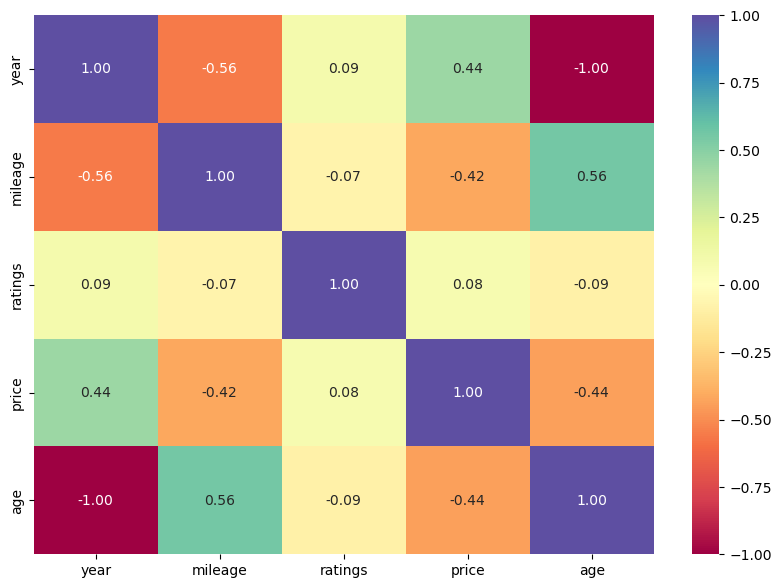

In [10]:
# Correlation check
cols_list = cars_df.select_dtypes(include = np.number).columns.tolist()

plt.figure(figsize = (10, 7))

sns.heatmap(
    cars_df[cols_list].corr(numeric_only = True), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral"
)

plt.show()

In [11]:
cars_df = pd.get_dummies(data = cars_df, drop_first= True)
cars_df.head()

,year,mileage,ratings,price,age,make_Alfa,make_Aston,make_Audi,make_BMW,make_Bentley,make_Buick,make_Cadillac,make_Chevrolet,make_Chrysler,make_Dodge,make_FIAT,make_Ferrari,make_Ford,make_GMC,make_Genesis,make_Honda,make_Hummer,make_Hyundai,make_INFINITI,make_Jaguar,make_Jeep,make_Kia,make_Land,make_Lexus,make_Lincoln,make_MINI,make_Maserati,make_Mazda,make_McLaren,make_Mercedes,make_Mercury,make_Mitsubishi,make_Nissan,make_Plymouth,make_Pontiac,make_Porsche,make_RAM,make_Rolls,make_Saab,make_Saturn,make_Scion,make_Subaru,make_Suzuki,make_Tesla,make_Toyota,make_Volkswagen,make_Volvo,make_smart,model_135,model_1500,model_200,model_2002,model_228,model_2500,model_300,model_300C,model_300ZX,model_320,model_325,model_328,model_328d,model_330,model_330e,model_335,model_340,model_348,model_3500,model_350Z,model_370Z,model_428,model_430,model_435,model_4Runner,model_500,model_500L,model_500X,model_528,model_530,model_530e,model_535,model_535d,model_540,model_550,model_570S,model_640,model_650,model_718,model_740,model_750,model_86,model_9,model_911,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_ALPINA,model_ATS,model_Acadia,model_Accent,model_Accord,model_Altima,model_Armada,model_Ascent,model_Atlas,model_Aura,model_Avalanche,model_Avalon,model_Avenger,model_B9,model_BRZ,model_Barracuda,model_Beetle,model_Benz,model_Blazer,model_Bolt,model_Boxster,model_C,model_C10,model_C30,model_C70,model_CC,model_CR,model_CT,model_CT6,model_CTS,model_CX,model_Cadenza,model_Caliber,model_Camaro,model_Camry,model_Canyon,model_Caprice,model_Cavalier,model_Cayenne,model_Cayman,model_Celica,model_Century,model_Challenger,model_Charger,model_Cherokee,model_Chevelle,model_City,model_Civic,model_Clarity,model_Clubman,model_Cobalt,model_Colorado,model_Commander,model_Compass,model_Continental,model_Convertible,model_Cooper,model_Corolla,model_Corvette,model_Cougar,model_Countryman,model_Crosstrek,model_Crown,model_Cruze,model_DTS,model_Dakota,model_Dart,model_DeVille,model_Durango,model_E,model_E250,model_E350,model_ECHO,model_ES,model_EX37,model_Eclipse,model_Edge,model_Elantra,model_Eldorado,model_Element,model_Enclave,model_Encore,model_Envision,model_Envoy,model_Eos,model_Equinox,model_Escalade,model_Escape,model_Excursion,model_Expedition,model_Explorer,model_Express,model_F,model_FJ,model_FR,model_FX35,model_Fiero,model_Fiesta,model_Fit,model_Five,model_Flex,model_Flying,model_Focus,model_ForTwo,model_Forester,model_Forte,model_Freestar,model_Frontier,model_Fusion,model_G25,model_G35,model_G37,model_G70,model_G80,model_G90,model_GS,model_GT,model_GTI,model_GX,model_Galant,model_Genesis,model_Ghibli,model_Golf,model_GranTurismo,model_Grand,model_H2,model_H3,model_HR,model_Hardtop,model_Highlander,model_I35,model_ILX,model_IS,model_Impala,model_Impreza,model_Insight,model_Ion,model_JX35,model_Jetta,model_Journey,model_Juke,model_K900,model_Kona,model_LC,model_LS,model_LX,model_LaCrosse,model_Lancer,model_Land,model_LeSabre,model_Leaf,model_Legacy,model_Levante,model_Liberty,model_Lucerne,model_M2,model_M235,model_M240,model_M3,model_M37,model_M4,model_M5,model_M550,model_M6,model_M760,model_MDX,model_MKC,model_MKS,model_MKX,model_MKZ,model_MX,model_Macan,model_Malibu,model_Mariner,model_Mark,model_Martin,model_Matrix,model_Maxima,model_Mazda2,model_Mazda3,model_Mazda5,model_Mazda6,model_Milan,model_Mirage,model_Model,model_Murano,model_Mustang,model_NSX,model_NV200,model_NX,model_Navigator,model_New,model_Niro,model_Odyssey,model_Optima,model_Outback,model_Outlander,model_Outlook,model_PT,model_Pacifica,model_Panamera,model_Passat,model_Pathfinder,model_Patriot,model_Phaeton,model_Pilot,model_Prius,model_ProMaster,model_Prowler,model_Q3,model_Q5,model_Q50,model_Q60,model_Q7,model_Q70,model_Q70L,model_Q8,model_QX30,model_QX50,model_QX56,model_QX60,model_QX80,model_Quattroporte,model_Quest,model_R32,model_R8,model_RAV4,model_RC,model_RDX,model_RL,model_RLX,model_RS,model_RX,model_Rabbit,model_Ram,model_Ranger,model_Regal,model_Renegade,model

In [12]:
X = cars_df.drop(['year', 'price'], axis = 1)
y = cars_df['price']

In [13]:
X.columns.tolist()

['mileage',
 'ratings',
 'age',
 'make_Alfa',
 'make_Aston',
 'make_Audi',
 'make_BMW',
 'make_Bentley',
 'make_Buick',
 'make_Cadillac',
 'make_Chevrolet',
 'make_Chrysler',
 'make_Dodge',
 'make_FIAT',
 'make_Ferrari',
 'make_Ford',
 'make_GMC',
 'make_Genesis',
 'make_Honda',
 'make_Hummer',
 'make_Hyundai',
 'make_INFINITI',
 'make_Jaguar',
 'make_Jeep',
 'make_Kia',
 'make_Land',
 'make_Lexus',
 'make_Lincoln',
 'make_MINI',
 'make_Maserati',
 'make_Mazda',
 'make_McLaren',
 'make_Mercedes',
 'make_Mercury',
 'make_Mitsubishi',
 'make_Nissan',
 'make_Plymouth',
 'make_Pontiac',
 'make_Porsche',
 'make_RAM',
 'make_Rolls',
 'make_Saab',
 'make_Saturn',
 'make_Scion',
 'make_Subaru',
 'make_Suzuki',
 'make_Tesla',
 'make_Toyota',
 'make_Volkswagen',
 'make_Volvo',
 'make_smart',
 'model_135',
 'model_1500',
 'model_200',
 'model_2002',
 'model_228',
 'model_2500',
 'model_300',
 'model_300C',
 'model_300ZX',
 'model_320',
 'model_325',
 'model_328',
 'model_328d',
 'model_330',
 'mo

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [26]:
# Gradient Boosting Regressor for predicting car prices
model_xgb = GradientBoostingRegressor(n_estimators = 200, random_state = 42, max_depth = 5)
model_xgb

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [27]:
# fit the training data
model_xgb.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [28]:
# get the predicted values from the test set
train_predicted = model_xgb.predict(X_train)
# print(predicted)
print("R-square:" + " " + str(r2_score(y_train, train_predicted)))

R-square: 0.9042202723433568


In [29]:
# get the predicted values from the test set
predicted = model_xgb.predict(X_test)
# print(predicted)
print("R-square:" + " " + str(r2_score(y_test, predicted)))

R-square: 0.8743435132227182


In [30]:
joblib.dump(model_xgb, 'xgb_model.pkl', compress = 9)

['xgb_model.pkl']

In [21]:
# load the model from disk
filename = 'xgb_model.pkl' 
loaded_model = joblib.load(open(filename, 'rb'))

result = loaded_model.score(X_test, y_test)
print(result)

0.90190651331017


In [22]:
MAK = list(df['make'].unique())

YR = []
for l in range(2000, 2019):
    YR.append(l)   

ML = []
for m in range(0, 10000000):
    M = round(m*0.01, 2)
    ML.append(M)

RT = []
for n in range(1, 51):
    R = round(n*0.1, 2)
    RT.append(R)

In [23]:
def Car(MAKE1, YEAR, MILEAGE, RATE):
    for j in MAK:
        print(j, end = "  ")

    Correct = False

    while(Correct == False):
        print("\n")
        MAKE1 = input("Select Make: ")
        print("\n")
        if MAKE1 in MAK:
            MAKE1 = MAKE1
            Correct = True
        else:
            print("Select from the listed Make only ")
            print("\n")
    
    MODEL = list(df[df['make']== MAKE1]['model'].unique())

    for k in MODEL:
        print(k, end = "  ")
    print("\n")
    Correct1 = False

    while(Correct1 == False):
        MODEL1 = input("Select Model:")
        if MODEL1 in MODEL:
            MODEL1 = MODEL1
            Correct1 = True
        else:
            print("Select from the listed Model only ")

    print("\n")
    
    Correct2 = False
    while(Correct2 == False):
        try:
            YEAR = int(input("Select Year in range between 2000 and 2019: "))
            if YEAR in YR:
                YEAR = YEAR
                Correct2 = True
        except ValueError:
            print("Select the year from the specified range")
    print("\n")
    
    Correct3 = False
    while(Correct3 == False):
        try:
            MILEAGE = float(input("Select Mileage: "))
            if MILEAGE in ML:
                MILEAGE = MILEAGE
                Correct3 = True
            else:
                print("Select the Mileage in between the range 0 and 100000:") 
        except:
            print("Select the Mileage in between the range 0 and 100000:")
    print("\n")
    
    Correct4 = False
    while(Correct4 == False):
        try:
            RATE = float(input("Select Ratings: "))
            if RATE in RT:
                RATE = RATE
                Correct4 = True
            else:
                print("Select the Ratings in between the range 0 and 5") 
        except:
            print("Select the Ratings in between the range 0 and 5")
    user_input11 = {'year':YEAR, 'mileage':MILEAGE , 'ratings':RATE, 'make':MAKE1, 'model':MODEL1}
    return(user_input11)

In [24]:
print(cars_df.shape)
cars_df.head(2)

(4950, 456)


,year,mileage,ratings,price,age,make_Alfa,make_Aston,make_Audi,make_BMW,make_Bentley,make_Buick,make_Cadillac,make_Chevrolet,make_Chrysler,make_Dodge,make_FIAT,make_Ferrari,make_Ford,make_GMC,make_Genesis,make_Honda,make_Hummer,make_Hyundai,make_INFINITI,make_Jaguar,make_Jeep,make_Kia,make_Land,make_Lexus,make_Lincoln,make_MINI,make_Maserati,make_Mazda,make_McLaren,make_Mercedes,make_Mercury,make_Mitsubishi,make_Nissan,make_Plymouth,make_Pontiac,make_Porsche,make_RAM,make_Rolls,make_Saab,make_Saturn,make_Scion,make_Subaru,make_Suzuki,make_Tesla,make_Toyota,make_Volkswagen,make_Volvo,make_smart,model_135,model_1500,model_200,model_2002,model_228,model_2500,model_300,model_300C,model_300ZX,model_320,model_325,model_328,model_328d,model_330,model_330e,model_335,model_340,model_348,model_3500,model_350Z,model_370Z,model_428,model_430,model_435,model_4Runner,model_500,model_500L,model_500X,model_528,model_530,model_530e,model_535,model_535d,model_540,model_550,model_570S,model_640,model_650,model_718,model_740,model_750,model_86,model_9,model_911,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_ALPINA,model_ATS,model_Acadia,model_Accent,model_Accord,model_Altima,model_Armada,model_Ascent,model_Atlas,model_Aura,model_Avalanche,model_Avalon,model_Avenger,model_B9,model_BRZ,model_Barracuda,model_Beetle,model_Benz,model_Blazer,model_Bolt,model_Boxster,model_C,model_C10,model_C30,model_C70,model_CC,model_CR,model_CT,model_CT6,model_CTS,model_CX,model_Cadenza,model_Caliber,model_Camaro,model_Camry,model_Canyon,model_Caprice,model_Cavalier,model_Cayenne,model_Cayman,model_Celica,model_Century,model_Challenger,model_Charger,model_Cherokee,model_Chevelle,model_City,model_Civic,model_Clarity,model_Clubman,model_Cobalt,model_Colorado,model_Commander,model_Compass,model_Continental,model_Convertible,model_Cooper,model_Corolla,model_Corvette,model_Cougar,model_Countryman,model_Crosstrek,model_Crown,model_Cruze,model_DTS,model_Dakota,model_Dart,model_DeVille,model_Durango,model_E,model_E250,model_E350,model_ECHO,model_ES,model_EX37,model_Eclipse,model_Edge,model_Elantra,model_Eldorado,model_Element,model_Enclave,model_Encore,model_Envision,model_Envoy,model_Eos,model_Equinox,model_Escalade,model_Escape,model_Excursion,model_Expedition,model_Explorer,model_Express,model_F,model_FJ,model_FR,model_FX35,model_Fiero,model_Fiesta,model_Fit,model_Five,model_Flex,model_Flying,model_Focus,model_ForTwo,model_Forester,model_Forte,model_Freestar,model_Frontier,model_Fusion,model_G25,model_G35,model_G37,model_G70,model_G80,model_G90,model_GS,model_GT,model_GTI,model_GX,model_Galant,model_Genesis,model_Ghibli,model_Golf,model_GranTurismo,model_Grand,model_H2,model_H3,model_HR,model_Hardtop,model_Highlander,model_I35,model_ILX,model_IS,model_Impala,model_Impreza,model_Insight,model_Ion,model_JX35,model_Jetta,model_Journey,model_Juke,model_K900,model_Kona,model_LC,model_LS,model_LX,model_LaCrosse,model_Lancer,model_Land,model_LeSabre,model_Leaf,model_Legacy,model_Levante,model_Liberty,model_Lucerne,model_M2,model_M235,model_M240,model_M3,model_M37,model_M4,model_M5,model_M550,model_M6,model_M760,model_MDX,model_MKC,model_MKS,model_MKX,model_MKZ,model_MX,model_Macan,model_Malibu,model_Mariner,model_Mark,model_Martin,model_Matrix,model_Maxima,model_Mazda2,model_Mazda3,model_Mazda5,model_Mazda6,model_Milan,model_Mirage,model_Model,model_Murano,model_Mustang,model_NSX,model_NV200,model_NX,model_Navigator,model_New,model_Niro,model_Odyssey,model_Optima,model_Outback,model_Outlander,model_Outlook,model_PT,model_Pacifica,model_Panamera,model_Passat,model_Pathfinder,model_Patriot,model_Phaeton,model_Pilot,model_Prius,model_ProMaster,model_Prowler,model_Q3,model_Q5,model_Q50,model_Q60,model_Q7,model_Q70,model_Q70L,model_Q8,model_QX30,model_QX50,model_QX56,model_QX60,model_QX80,model_Quattroporte,model_Quest,model_R32,model_R8,model_RAV4,model_RC,model_RDX,model_RL,model_RLX,model_RS,model_RX,model_Rabbit,model_Ram,model_Ranger,model_Regal,model_Renegade,model

In [25]:
print(X_train.shape)
X_train.head(2)

(3960, 454)


,mileage,ratings,age,make_Alfa,make_Aston,make_Audi,make_BMW,make_Bentley,make_Buick,make_Cadillac,make_Chevrolet,make_Chrysler,make_Dodge,make_FIAT,make_Ferrari,make_Ford,make_GMC,make_Genesis,make_Honda,make_Hummer,make_Hyundai,make_INFINITI,make_Jaguar,make_Jeep,make_Kia,make_Land,make_Lexus,make_Lincoln,make_MINI,make_Maserati,make_Mazda,make_McLaren,make_Mercedes,make_Mercury,make_Mitsubishi,make_Nissan,make_Plymouth,make_Pontiac,make_Porsche,make_RAM,make_Rolls,make_Saab,make_Saturn,make_Scion,make_Subaru,make_Suzuki,make_Tesla,make_Toyota,make_Volkswagen,make_Volvo,make_smart,model_135,model_1500,model_200,model_2002,model_228,model_2500,model_300,model_300C,model_300ZX,model_320,model_325,model_328,model_328d,model_330,model_330e,model_335,model_340,model_348,model_3500,model_350Z,model_370Z,model_428,model_430,model_435,model_4Runner,model_500,model_500L,model_500X,model_528,model_530,model_530e,model_535,model_535d,model_540,model_550,model_570S,model_640,model_650,model_718,model_740,model_750,model_86,model_9,model_911,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_ALPINA,model_ATS,model_Acadia,model_Accent,model_Accord,model_Altima,model_Armada,model_Ascent,model_Atlas,model_Aura,model_Avalanche,model_Avalon,model_Avenger,model_B9,model_BRZ,model_Barracuda,model_Beetle,model_Benz,model_Blazer,model_Bolt,model_Boxster,model_C,model_C10,model_C30,model_C70,model_CC,model_CR,model_CT,model_CT6,model_CTS,model_CX,model_Cadenza,model_Caliber,model_Camaro,model_Camry,model_Canyon,model_Caprice,model_Cavalier,model_Cayenne,model_Cayman,model_Celica,model_Century,model_Challenger,model_Charger,model_Cherokee,model_Chevelle,model_City,model_Civic,model_Clarity,model_Clubman,model_Cobalt,model_Colorado,model_Commander,model_Compass,model_Continental,model_Convertible,model_Cooper,model_Corolla,model_Corvette,model_Cougar,model_Countryman,model_Crosstrek,model_Crown,model_Cruze,model_DTS,model_Dakota,model_Dart,model_DeVille,model_Durango,model_E,model_E250,model_E350,model_ECHO,model_ES,model_EX37,model_Eclipse,model_Edge,model_Elantra,model_Eldorado,model_Element,model_Enclave,model_Encore,model_Envision,model_Envoy,model_Eos,model_Equinox,model_Escalade,model_Escape,model_Excursion,model_Expedition,model_Explorer,model_Express,model_F,model_FJ,model_FR,model_FX35,model_Fiero,model_Fiesta,model_Fit,model_Five,model_Flex,model_Flying,model_Focus,model_ForTwo,model_Forester,model_Forte,model_Freestar,model_Frontier,model_Fusion,model_G25,model_G35,model_G37,model_G70,model_G80,model_G90,model_GS,model_GT,model_GTI,model_GX,model_Galant,model_Genesis,model_Ghibli,model_Golf,model_GranTurismo,model_Grand,model_H2,model_H3,model_HR,model_Hardtop,model_Highlander,model_I35,model_ILX,model_IS,model_Impala,model_Impreza,model_Insight,model_Ion,model_JX35,model_Jetta,model_Journey,model_Juke,model_K900,model_Kona,model_LC,model_LS,model_LX,model_LaCrosse,model_Lancer,model_Land,model_LeSabre,model_Leaf,model_Legacy,model_Levante,model_Liberty,model_Lucerne,model_M2,model_M235,model_M240,model_M3,model_M37,model_M4,model_M5,model_M550,model_M6,model_M760,model_MDX,model_MKC,model_MKS,model_MKX,model_MKZ,model_MX,model_Macan,model_Malibu,model_Mariner,model_Mark,model_Martin,model_Matrix,model_Maxima,model_Mazda2,model_Mazda3,model_Mazda5,model_Mazda6,model_Milan,model_Mirage,model_Model,model_Murano,model_Mustang,model_NSX,model_NV200,model_NX,model_Navigator,model_New,model_Niro,model_Odyssey,model_Optima,model_Outback,model_Outlander,model_Outlook,model_PT,model_Pacifica,model_Panamera,model_Passat,model_Pathfinder,model_Patriot,model_Phaeton,model_Pilot,model_Prius,model_ProMaster,model_Prowler,model_Q3,model_Q5,model_Q50,model_Q60,model_Q7,model_Q70,model_Q70L,model_Q8,model_QX30,model_QX50,model_QX56,model_QX60,model_QX80,model_Quattroporte,model_Quest,model_R32,model_R8,model_RAV4,model_RC,model_RDX,model_RL,model_RLX,model_RS,model_RX,model_Rabbit,model_Ram,model_Ranger,model_Regal,model_Renegade,model_Ridgeline,

In [26]:
def input_to_one_hot(data):
    # initialize the target vector with zero values
    enc_input = np.zeros(454)

    # set the numerical input as they are
    enc_input[0] = data['mileage']
    enc_input[1] = data['ratings']
    enc_input[2] = datetime.now().year - data['year']

    ##################### Make #########################
    # get the array of make categories
    Make = df.make.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'make_' + data['make']
    # search for the index in columns name list 
    Make_column_index = X.columns.tolist().index(redefinded_user_input)
    
    # fullfill the found index with 1
    enc_input[Make_column_index] = 1
    ##################### Model ####################
    # get the array of Model
    Model = df.model.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'model_'+ data['model']
    # search for the index in columns name list 
    Model_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[Model_column_index] = 1
    return enc_input

In [27]:
def Price(P):
    a = input_to_one_hot(P)
    price_pred = loaded_model.predict([a])
    return(price_pred[0])

In [28]:
Predic = Price(Car(MAK, YR, ML, RT))
print("Price for the selected car:", Predic)

Saturn  Toyota  Acura  Dodge  Ford  Honda  Lexus  Audi  BMW  Volvo  Jeep  Aston  Chevrolet  Maserati  Subaru  Saab  Land  Mercedes  Porsche  Mazda  Kia  Nissan  GMC  INFINITI  Jaguar  RAM  Volkswagen  Tesla  Cadillac  smart  Hyundai  Scion  Pontiac  FIAT  Chrysler  MINI  Lincoln  Genesis  Ferrari  Mitsubishi  Bentley  Buick  Alfa  Mercury  Rolls  Suzuki  Hummer  Plymouth  McLaren  

Select Make: Honda


Accord  CR  Civic  Pilot  Fit  Odyssey  S2000  Ridgeline  Element  Clarity  Insight  HR  

Select Model:Civic


Select Year in range between 2000 and 2019: 2012


Select Mileage: 95000


Select Ratings: 4.5
Price for the selected car: 8320.479


### Scrape Car Images

In [ ]:
from bs4 import BeautifulSoup
import requests
import http.cookiejar
import urllib.request
import os
os.getcwd()

In [ ]:
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import urllib.request

In [ ]:
for i in sorted(MAK):
    MODEL = Cars3[i]
    MODEL = sorted(list(set(MODEL)))
    for j in MODEL:
        url = "https://www.shutterstock.com/search/" + i + "+" + j
        try:
            driver = webdriver.Safari()
            driver.get(url)
            print(url)
            ids = driver.find_elements_by_tag_name("img")
            a = ids[0].get_attribute('src')
            imagefile = open(i+"_"+j + ".png", "wb")
            imagefile.write(urllib.request.urlopen(a).read())
            imagefile.close()
            time.sleep(0.5)
            driver.quit()
        except:
            print("Images not found")

### Dash

In [29]:
MIL = []
for m in range(1, 1000):
    M = round(m*100, 2)
    MIL.append(M)

In [32]:
# Creating an dashboard application
app = dash.Dash()

b_image_filename = '../car_images/Honda_Accord.png'
b_encoded_image = base64.b64encode(open(b_image_filename, 'rb').read())

app.layout = html.Div([
    
    # To give Title
    html.Div([
        
        html.Div([
            html.H1('Car Prices'),
        ])
    ], style = {'textAlign': 'center'}),
    
    html.Hr(),
    
    html.Div(style = {'background-image': 'url(https://www.shutterfly.com/ideas/wp-content/uploads/2016/08/50-happy-birthday-quotes-thumb.jpg)'}),
    
    html.Div([
        
        # To display car name
        html.Div(id = 'Car_name',
        style = {'color': 'Black'}),
        
        
        # To display car image
        html.Img(id = 'car_image')
    ], style = {'fontsize': 500, 'textAlign': 'center'}),
    
    html.Hr(),
    
    #html component for Make
    html.Div([
        html.H3('Select Make'),
        
        # Dropdown menu to select Make
        dcc.Dropdown(
            id = 'Make',
            options = [
                {'label': i, 'value': i} for i in sorted(MAK)
            ],
            value = 'Honda'
        )
    ], style={'display':'inline-block', 'verticalAlign':'top', 'width':'45%', 'textAlign':'center'}),
    
    
    #html component for Model
    html.Div([
        html.H3('Select Model'),
        
        # Dropdown menu to select Model
        dcc.Dropdown(
            id = 'Model',
        )
    ], style={'display':'inline-block', 'verticalAlign':'top', 'width':'45%', 'textAlign':'center'}),
    
    
    #html component for Year
    html.Div([
        html.H3('Select Year'),
        
        # Dropdown menu to select Year
        dcc.Dropdown(
            id = 'Year',
            options = [
                {'label': i, 'value': i} for i in YR
            ],
            value = 2010
        )
    ], style={'display':'inline-block', 'verticalAlign':'top', 'width':'45%', 'textAlign':'center'}),
    
    #html component for Milage
    html.Div([
        html.H3('Select Milage'),
        
        # Dropdown menu to select Milage
        dcc.Dropdown(
            id = 'Mileage',
            options = [
                {'label': i, 'value': i} for i in MIL
            ],
            value = 85000
        )
    ], style={'display':'inline-block', 'verticalAlign':'top', 'width':'45%', 'textAlign':'center'}),
    
    #html component for Ratings
    html.Div([
        html.H3('Select Ratings'),
        
        # Dropdown menu to select Ratings
        dcc.Dropdown(
            id = 'Ratings',
            options = [
                {'label': i, 'value': i} for i in RT
            ],
            value = 4.3
        )
    ], style={'display':'inline-block', 'verticalAlign':'top', 'width':'45%', 'textAlign':'center'}),
    
    
    
    # html division to give action button
    html.Div([
        
        html.H3('Click Submit to View Results'),
        
        html.Button(
            id='submit-button',
            n_clicks=0,
            children = 'Submit',
            style={'fontSize':18}
        ),
    ], style = {'display':'inline-block', 'width':'45%', 'textAlign':'center'}),
    
    
    # To seperate different html components
    html.Hr(),
    
    # Car Price
    html.Div([
        html.Div(id = 'Car_Price',
        style = {'color': 'darkmagenta'}),
    ], style = {'fontsize': 30, 'textAlign':'center'})
       
])



# To update the options in dropdown menu of Select model
@app.callback(
    Output('Model', 'options'),
    [Input('Make', 'value')]
)
def update_dropdown(value):

    MODEL = list(df[df['make']== value]['model'].unique())
    
    model_options = [{'label': i, 'value': i} for i in sorted(MODEL)]
    
    return model_options

# To update the selected values in the dropdown menu of Select model
@app.callback(
    Output('Model', 'value'),
    [Input('Model', 'options')])

def set_dropdown_value(available_options):
    
    Value = available_options[0]['value']
    
    return Value


# To display predicted price of selected car
@app.callback(
    
    Output('Car_Price', 'children'),
    [Input('submit-button', 'n_clicks')],
    [State('Model', 'value'),
     State('Mileage', 'value'),
     State('Year', 'value'),
     State('Ratings', 'value'),
     State('Make', 'value')]
)

# updates the predicted price of selected car

def car_pred(n_clicks, model, mileage, year, ratings, make):
    
    if model == None:
        model = 'Accord'

            
    user_input = {'mileage': mileage , 'ratings': ratings, 'year': year, 'make': make, 'model': model}
    
    price = Price(user_input)
    
    return ("Predicted price is {}".format(price))


# To display image of selected car
@app.callback(
    
    Output('Car_name', 'children'),
    [Input('submit-button', 'n_clicks')],
    [State('Model', 'value'),
     State('Make', 'value')]
)

def car_name(n_clicks, model, make):
    
    if model == None:
        model = 'Accord'
        
    Car_name = make + " " +model
    
    return ("{}".format(Car_name))

# To display image of selected car
@app.callback(
    
    Output('car_image', 'src'),
    [Input('submit-button', 'n_clicks')],
    [State('Model', 'value'),
     State('Make', 'value')]
)

def car_image(n_clicks, model, make):
    
    if model == None:
        model = 'Accord'
        
    image_filename = "../car_images/" + make + "_" + model + ".png"    

    encoded_image = base64.b64encode(open(image_filename, 'rb').read())
    
    src ='data:image/png;base64,{}'.format(encoded_image.decode())
    
    return src

if __name__ == '__main__':
    app.run_server()

### Flask

In [ ]:
# load the built-in model 
gbr = joblib.load('model.pkl')

app = Flask(__name__)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/api', methods=['POST'])
def get_delay():
    data1 = request.get_json()
    Year = data1['year']
    Mileage = data1['mileage']
    Make = data1['make']
    Ratings = data1['ratings']
    Model = data1['model']
    # we create a json object that will hold data from user inputs
    Input = {'year':Year, 'mileage':Mileage, 'ratings':Ratings, 'make':Make, 'model':Model}
    # encode the json object to one hot encoding so that it could fit our model
    a = input_to_one_hot(Car(MAK, YR, ML, RT))
    # get the price prediction
    price_pred = gbr.predict([a])[0]
    price_pred = round(price_pred, 2)
    # return a json value
    return json.dumps({'Price':price_pred});

if __name__ == '__main__':
    app.run()